### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Understanding the data

In [2]:
df = pd.read_csv("train.csv")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
df.shape


(421570, 5)

In [4]:

df.size

2107850

In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [6]:
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [7]:
df.columns


Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

### 1. Data Cleaning & Preparation 
---->Convert date column to DateTime format 

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()



,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [9]:
df.columns # the date coulmns is not removed it is moved to index

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday'], dtype='object')

----> Handle missing values

In [10]:
df.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

---->Resample data (daily/weekly/monthly) 

  Resampling is the process of converting time-series data into different time frequencies (daily, weekly, monthly) to analyze patterns at multiple levels.

--->Resampling is Required in Sales Forecasting

Raw sales data may be noisy

Different stakeholders need different time views

Forecasting models perform better on uniform time intervals


##### Daily Resampling

In [11]:
daily_sales = df['Weekly_Sales'].resample('D').sum()
daily_sales.head()

Date
2010-02-05    49750740.5
2010-02-06           0.0
2010-02-07           0.0
2010-02-08           0.0
2010-02-09           0.0
Freq: D, Name: Weekly_Sales, dtype: float64

##### Weekly Resampling

In [12]:
weekly_sales = df['Weekly_Sales'].resample('W').sum()
weekly_sales.head()

Date
2010-02-07    49750740.50
2010-02-14    48336677.63
2010-02-21    48276993.78
2010-02-28    43968571.13
2010-03-07    46871470.30
Freq: W-SUN, Name: Weekly_Sales, dtype: float64

##### Monthly Resampling

In [13]:
monthly_sales = df['Weekly_Sales'].resample('ME').sum()
monthly_sales.head()

Date
2010-02-28    1.903330e+08
2010-03-31    1.819198e+08
2010-04-30    2.314124e+08
2010-05-31    1.867109e+08
2010-06-30    1.922462e+08
Freq: ME, Name: Weekly_Sales, dtype: float64

In [14]:
#“I checked the index type to confirm it was a DatetimeIndex before performing resampling.”
type(df.index)


pandas.core.indexes.datetimes.DatetimeIndex

#### here we are not ploting for daily because it is a huge and if your dataset spans multiple years, plotting daily will produce a dense, almost unreadable line

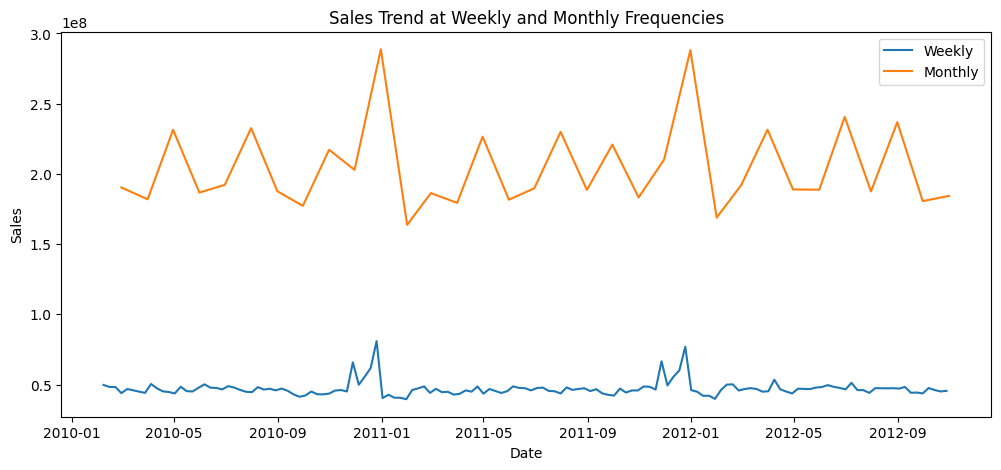

In [15]:
plt.figure(figsize=(12,5))
plt.plot(weekly_sales, label='Weekly')
plt.plot(monthly_sales, label='Monthly')
plt.legend()
plt.title("Sales Trend at Weekly and Monthly Frequencies")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


####  Manage outliers or inconsistent entries 

Outliers can distort forecasts, especially in sales data.

Examples: negative sales, abnormally high spikes (maybe data entry errors or Black Friday sales).

Goal: detect and manage them, not just blindly delete.

#### Detecting outliers

---> There are two methods to detect the outliers

       1. IQR Method(Interquartile Range)

       2.Z-Score Method(good for normal distributions)
       

##### IQR Method

In [16]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)

# Step 2: Compute IQR
IQR = Q3 - Q1

# Step 3: Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)


Lower bound: -25109.653749999998
Upper bound: 47395.15625


#### Z-SCORE

In [17]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(df['Weekly_Sales']))
outliers = np.where(z_scores > 3)  # z > 3 or z < -3 considered outlier
print("Number of outliers:", len(outliers[0]))


Number of outliers: 8848


Observation from this

->IQR Method:

Lower bound = -25,109 → sales can’t be negative, so we don’t have any really low outliers.

Upper bound = 47,395 → any weekly sales above this number are very high compared to normal.

->Z-score Method:

Number of outliers = 8,848 → about 8,800 weeks have sales that are much higher or lower than average.


->Conculsion from this:

Our dataset has big spikes in sales, probably because of holidays, Black Friday, or seasonal promotions.

These spikes are real events but can mess up forecasting if not handled properly.

#### Boxplot Before Handling Outliers

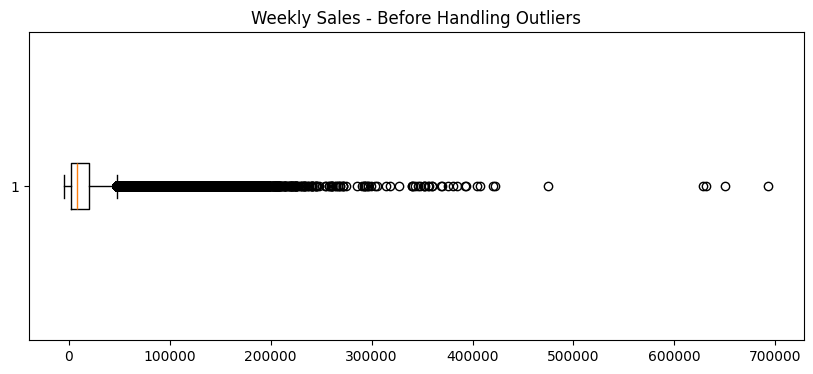

In [18]:
plt.figure(figsize=(10,4))
plt.boxplot(df['Weekly_Sales'], vert=False)
plt.title("Weekly Sales - Before Handling Outliers")
plt.show()


#### Handling Outliers

###### approach: Capping (Winsorization)
Instead of removing extreme sales (which could be real), we limit them to a maximum value (upper bound).

For lower bound, in our case it’s negative (impossible), so no need to change.

In [19]:
# Cap high outliers at the upper bound
df['Weekly_Sales_Capped'] = np.where(df['Weekly_Sales'] > upper_bound, upper_bound, df['Weekly_Sales'])

# Cap low outliers at the lower bound (optional, here it's negative so won't change anything)
df['Weekly_Sales_Capped'] = np.where(df['Weekly_Sales_Capped'] < lower_bound, lower_bound, df['Weekly_Sales_Capped'])


#### Boxplot After Handling Outliers

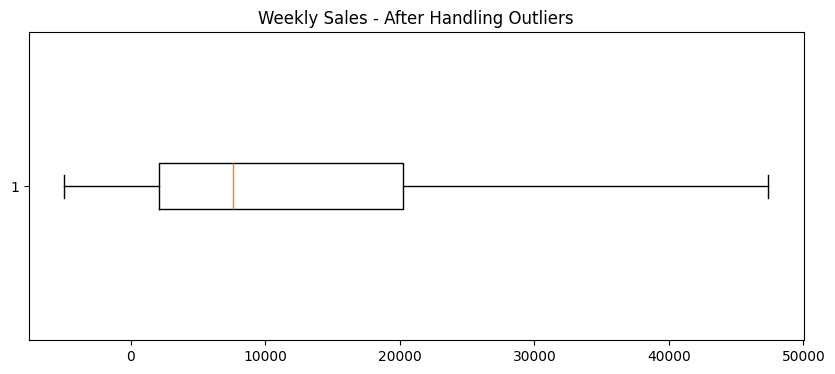

In [20]:
plt.figure(figsize=(10,4))
plt.boxplot(df['Weekly_Sales_Capped'], vert=False)
plt.title("Weekly Sales - After Handling Outliers")
plt.show()


### 2. Exploratory Data Analysis (EDA)

####  Trend plots 
--->To visualize how sales change over time and detect patterns.

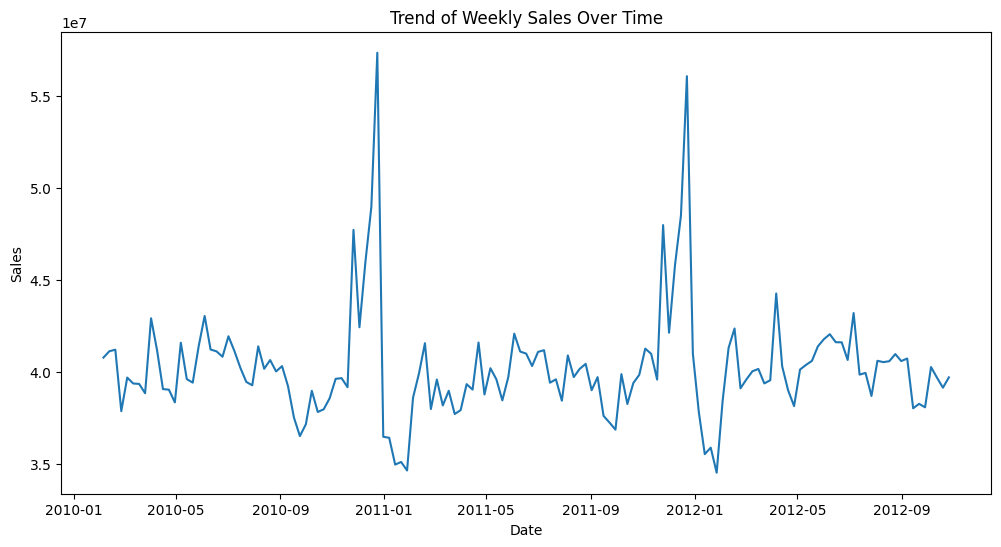

In [21]:
#  Group sales by Date
df_grouped = df.groupby('Date')['Weekly_Sales_Capped'].sum()

# Plot the trend
plt.figure(figsize=(12,6))
plt.plot(df_grouped)
plt.title('Trend of Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

#### Seasonal Behavior Analysis
--->To check if there are repeating patterns (weekly, monthly, yearly).
##### can be done in two types:
---> bar plot

---> box plot

##### 1.Extract Time Components

In [22]:
if isinstance(df.index, pd.DatetimeIndex):
    df.reset_index(inplace=True)
# Date becomes a normal column again
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter 

#Breaking the date into smaller time units lets us compare sales across different periods to detect seasonal trends.
monthly_sales = df.groupby('Month')['Weekly_Sales_Capped'].sum()
#Aggregating helps us see overall trends and peaks in sales clearly instead of looking at every single day.



#### Bar Plot – Total Sales per Month
--->Quickly shows which months are peak vs off-season

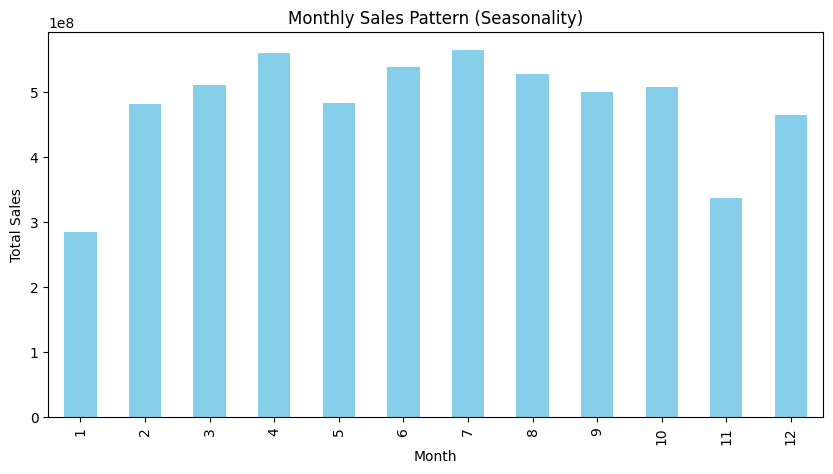

In [23]:
monthly_sales.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title('Monthly Sales Pattern (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()


#### Box Plot – Distribution per Month
--->Shows variation and outliers, giving deeper insight into sales consistency each month.

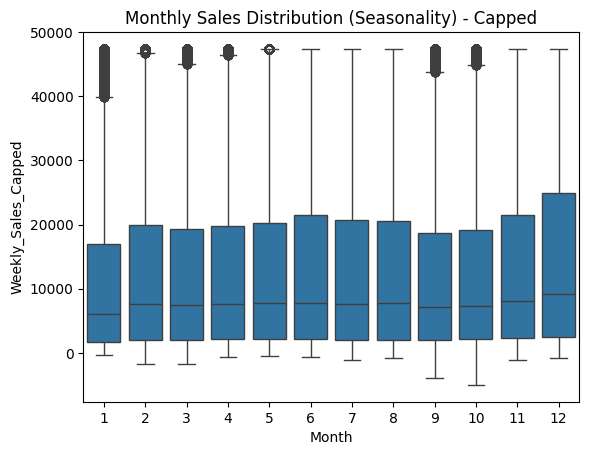

In [24]:
sns.boxplot(x='Month', y='Weekly_Sales_Capped', data=df)
plt.title('Monthly Sales Distribution (Seasonality) - Capped')
plt.show()


#### Seaborn still shows points as outliers

Seaborn calculates whiskers using 1.5×IQR rule:

##### Upper whisker
=
𝑄
3
+
1.5
×
𝐼
𝑄
𝑅
Upper whisker=Q3+1.5×IQR

Even after capping at upper_bound ≈ 47,395, the upper whisker calculated from the data (Q1, Q3) might be lower than 47,395

So Seaborn still treats those capped values as outliers

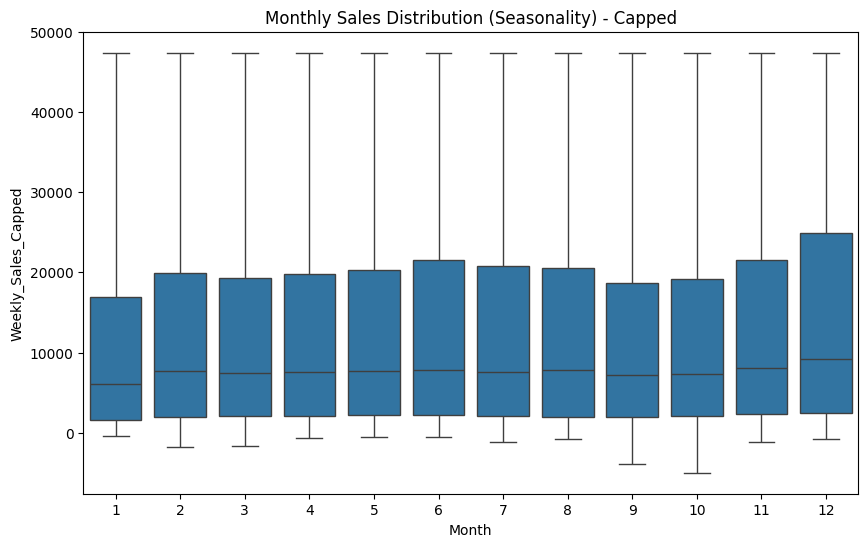

In [25]:
# Step 1: Recompute Q1, Q3, IQR on capped data
Q1 = df['Weekly_Sales_Capped'].quantile(0.25)
Q3 = df['Weekly_Sales_Capped'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Set whiskers to min/max of capped data instead of 1.5*IQR
lower_whisker = df['Weekly_Sales_Capped'].min()
upper_whisker = df['Weekly_Sales_Capped'].max()

# Step 3: Draw boxplot with manually set whiskers using matplotlib
plt.figure(figsize=(10,6))
sns.boxplot(x='Month', y='Weekly_Sales_Capped', data=df, whis=[0,100])  # whis=[0,100] sets whiskers to min/max
plt.title('Monthly Sales Distribution (Seasonality) - Capped')
plt.show()


#### Quarterly aggregation

quarterly_sales = df.groupby('Quarter')['Weekly_Sales_Capped'].sum()
sns.barplot(x=quarterly_sales.index, y=quarterly_sales.values, color='skyblue')
plt.title('Quarterly Sales Pattern')
plt.show()

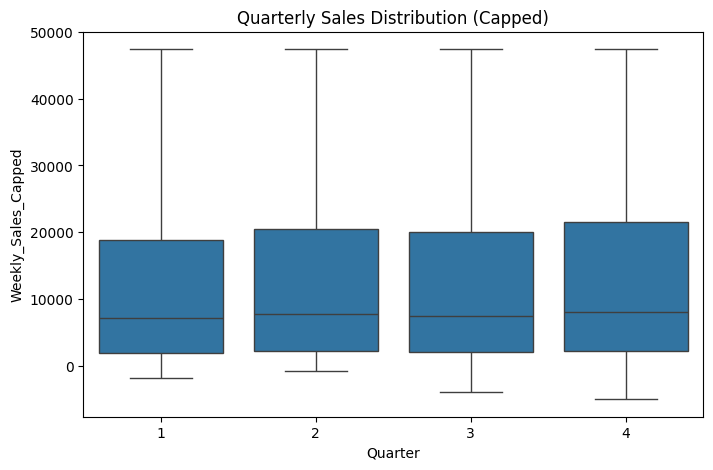

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Quarter', y='Weekly_Sales_Capped', data=df, whis=[0,100])  # whiskers = min/max
plt.title('Quarterly Sales Distribution (Capped)')
plt.show()


#### ● Holiday vs Normal day comparison 
Total Sales Comparison (Bar Plot)

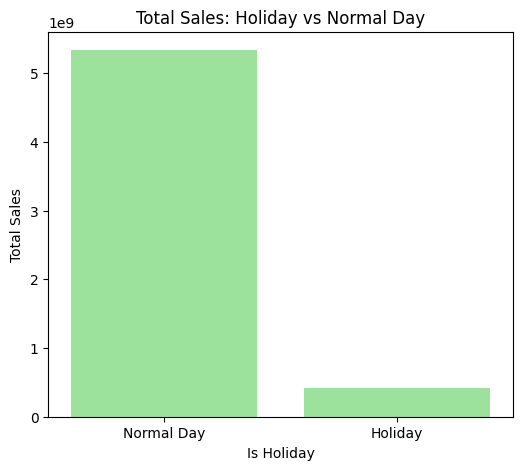

In [27]:
# Aggregate total sales by holiday
holiday_sales = df.groupby('IsHoliday')['Weekly_Sales_Capped'].sum()
plt.figure(figsize=(6,5))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values, color='lightgreen')
plt.title('Total Sales: Holiday vs Normal Day')
plt.xlabel('Is Holiday')
plt.ylabel('Total Sales')
plt.xticks([0,1], ['Normal Day', 'Holiday'])
plt.show()


#### Sales Distribution Comparison (Box Plot)

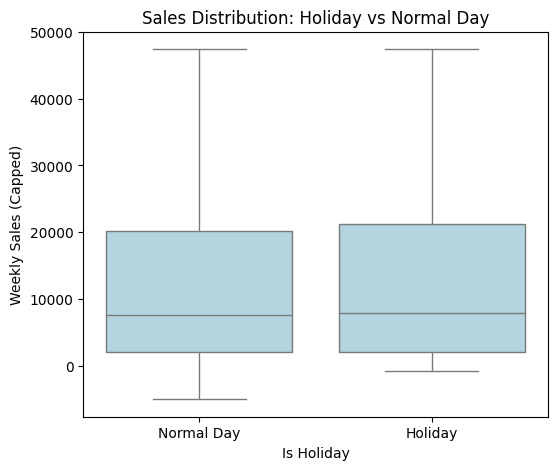

In [28]:
plt.figure(figsize=(6,5))
sns.boxplot(x='IsHoliday', y='Weekly_Sales_Capped', data=df, whis=[0,100], color='lightblue')  # single color
plt.title('Sales Distribution: Holiday vs Normal Day')
plt.xlabel('Is Holiday')
plt.ylabel('Weekly Sales (Capped)')
plt.xticks([0,1], ['Normal Day', 'Holiday'])
plt.show()


#### ● Category-wise sales distribution

Bar Plot – Total Sales per Department (Category)

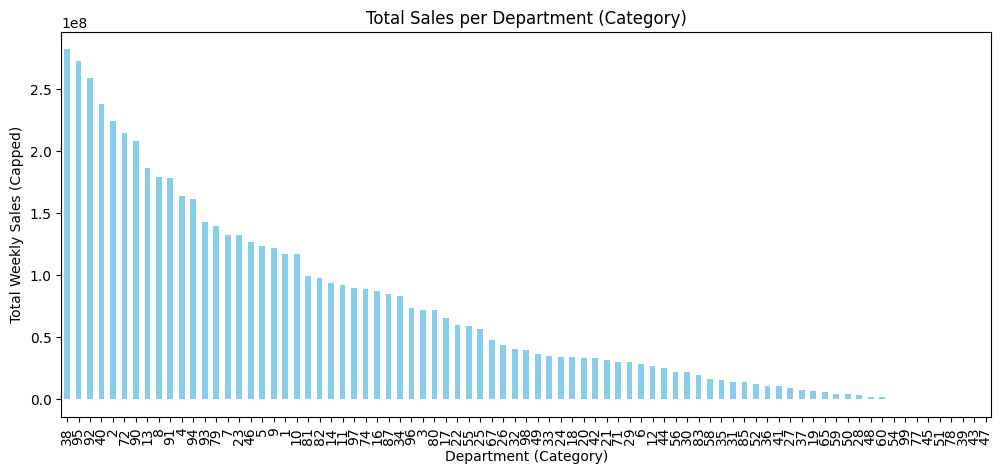

In [29]:
# Aggregate total sales per Dept (category)
dept_sales = df.groupby('Dept')['Weekly_Sales_Capped'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,5))
dept_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales per Department (Category)')
plt.xlabel('Department (Category)')
plt.ylabel('Total Weekly Sales (Capped)')
plt.show()


Box Plot – Distribution of Sales per Department

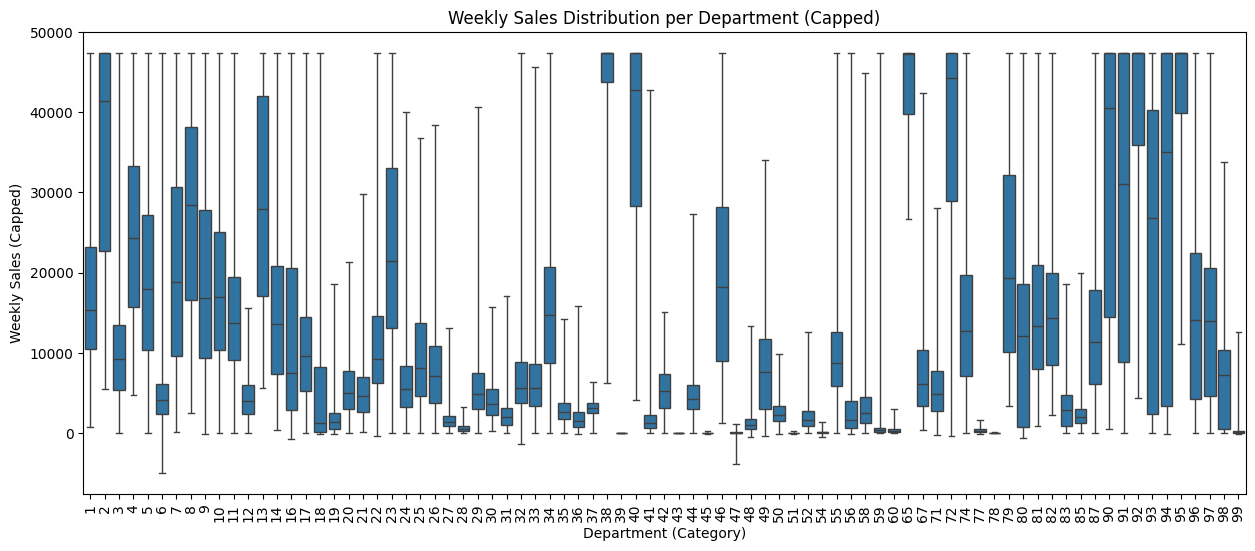

In [30]:
plt.figure(figsize=(15,6))
sns.boxplot(x='Dept', y='Weekly_Sales_Capped', data=df, whis=[0,100])
plt.title('Weekly Sales Distribution per Department (Capped)')
plt.xlabel('Department (Category)')
plt.ylabel('Weekly Sales (Capped)')
plt.xticks(rotation=90)  # rotate x-axis labels for readability
plt.show()


##### Even though we have done the Category-wise sales distribution for entire data .so we took top 10 values to understand it more clearly

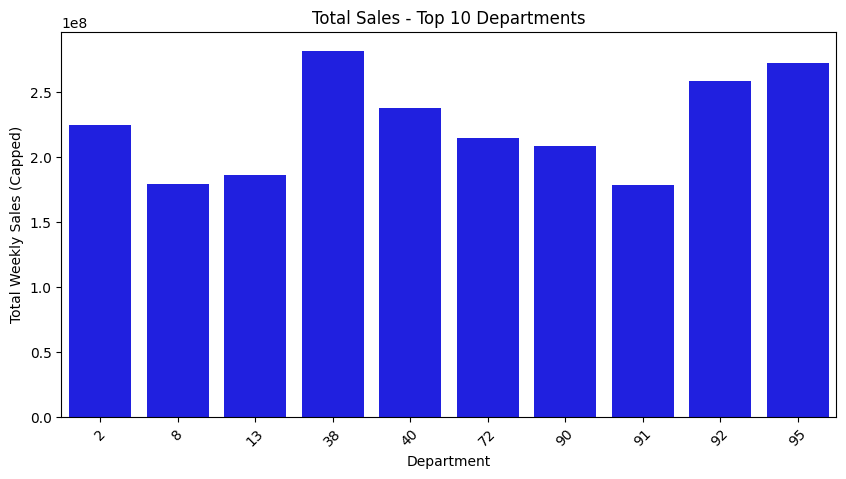

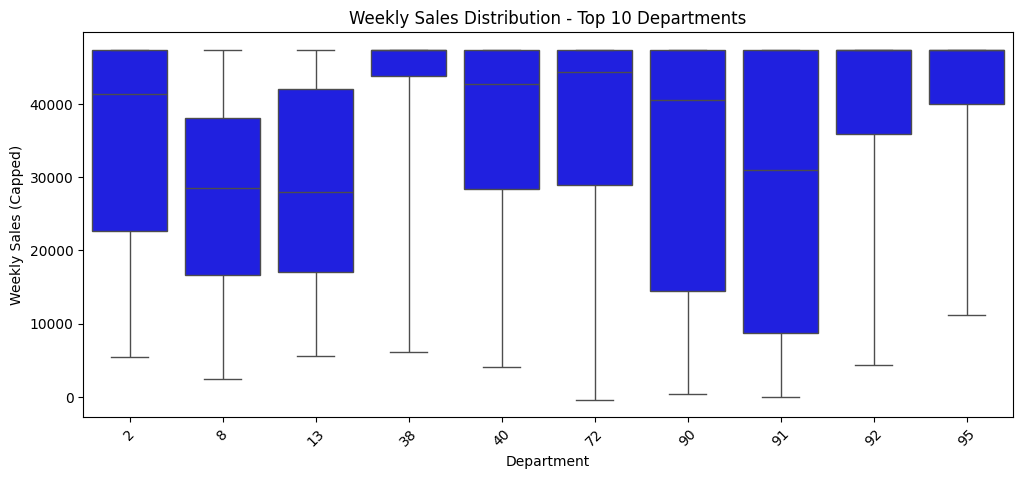

In [31]:
# Select top 10 departments
top10_depts = dept_sales.head(10).index
df_top10 = df[df['Dept'].isin(top10_depts)]

# --- Bar Plot: Total Sales per Top 10 Departments ---
plt.figure(figsize=(10,5))
sns.barplot(x=top10_depts, y=dept_sales[top10_depts].values, color='blue')
plt.title('Total Sales - Top 10 Departments')
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales (Capped)')
plt.xticks(rotation=45)
plt.show()

# --- Box Plot: Weekly Sales Distribution per Top 10 Departments ---
plt.figure(figsize=(12,5))
sns.boxplot(x='Dept', y='Weekly_Sales_Capped', data=df_top10, whis=[0,100], color='blue')
plt.title('Weekly Sales Distribution - Top 10 Departments')
plt.xlabel('Department')
plt.ylabel('Weekly Sales (Capped)')
plt.xticks(rotation=45)
plt.show()

#### ● Correlation analysis 
Correlation analysis measures how strongly numerical variables move together.

Values range from -1 to +1

+1 → strong positive relationship

-1 → strong negative relationship

0 → no relationship

In our dataset, correlation helps understand which factors influence Weekly Sales.

In [32]:
df.columns

Index(['Date', 'Store', 'Dept', 'Weekly_Sales', 'IsHoliday',
       'Weekly_Sales_Capped', 'Month', 'Quarter'],
      dtype='object')

#### for correlation we need to select the numerical columns :


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 421570 non-null  datetime64[ns]
 1   Store                421570 non-null  int64         
 2   Dept                 421570 non-null  int64         
 3   Weekly_Sales         421570 non-null  float64       
 4   IsHoliday            421570 non-null  bool          
 5   Weekly_Sales_Capped  421570 non-null  float64       
 6   Month                421570 non-null  int32         
 7   Quarter              421570 non-null  int32         
dtypes: bool(1), datetime64[ns](1), float64(2), int32(2), int64(2)
memory usage: 19.7 MB


In [34]:
# Select numerical columns
corr_data = df[['Weekly_Sales_Capped', 'Store', 'Dept', 'IsHoliday', 'Month', 'Quarter']]


##### Compute Correlation Matrix

In [35]:
corr_matrix = corr_data.corr()
corr_matrix
# this gives the correlation values Table

,Weekly_Sales_Capped,Store,Dept,IsHoliday,Month,Quarter
Weekly_Sales_Capped,1.000000,-0.076752,0.102538,0.006511,0.026760,0.022470
Store,-0.076752,1.000000,0.024004,-0.000548,0.001011,0.001036
Dept,0.102538,0.024004,1.000000,0.000916,0.000904,0.000723
IsHoliday,0.006511,-0.000548,0.000916,1.000000,0.123376,0.081870
Month,0.026760,0.001011,0.000904,0.123376,1.000000,0.967164
Quarter,0.022470,0.001036,0.000723,0.081870,0.967164,1.000000


#### Correlation Heatmap

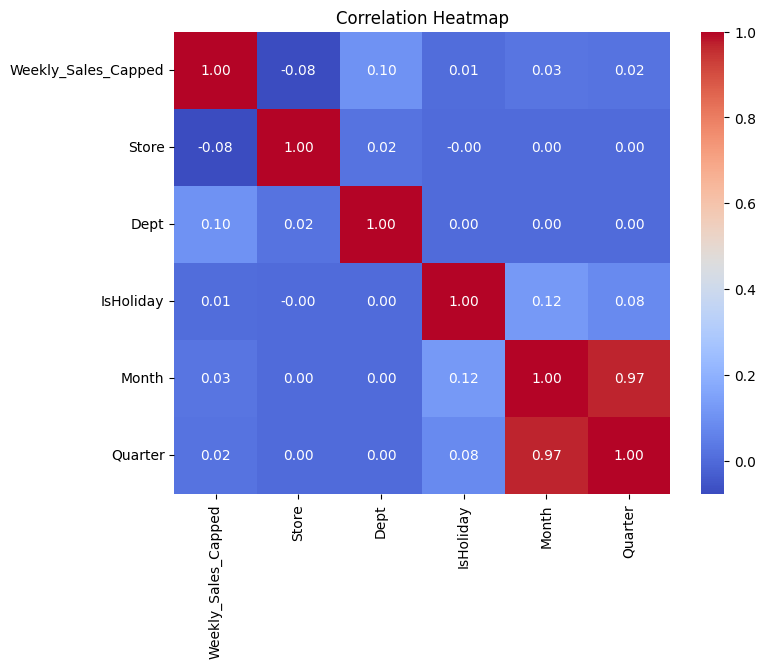

In [36]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


Observation:

Weekly_Sales_Capped has low correlation with IsHoliday
→ Holidays affect sales, but not strongly across all stores/departments.

Store and Dept show weak correlation with sales
→ Sales depend more on time-based and external factors.

Month and Quarter show mild correlation
→ Confirms seasonal patterns.

### Forecasting Model Development
Forecasting models are used to predict future sales based on historical data and patterns.

### Prophet Model

Handles trend + seasonality + holidays automatically

Easy to implement

Excellent for time-series sales data

In [37]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


MAE → average prediction error in sales units

RMSE → penalizes large errors more

MAPE → average percentage error (easy to interpret)

Importing plotly failed. Interactive plots will not work.
16:08:36 - cmdstanpy - INFO - Chain [1] start processing
16:08:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Evaluation Metrics
MSE : 517760385527.53815
RMSE: 719555.6861894277
MAPE : 1.241889540070726 %


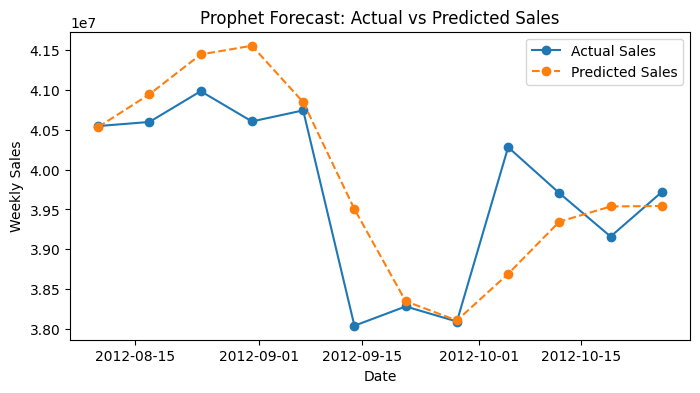

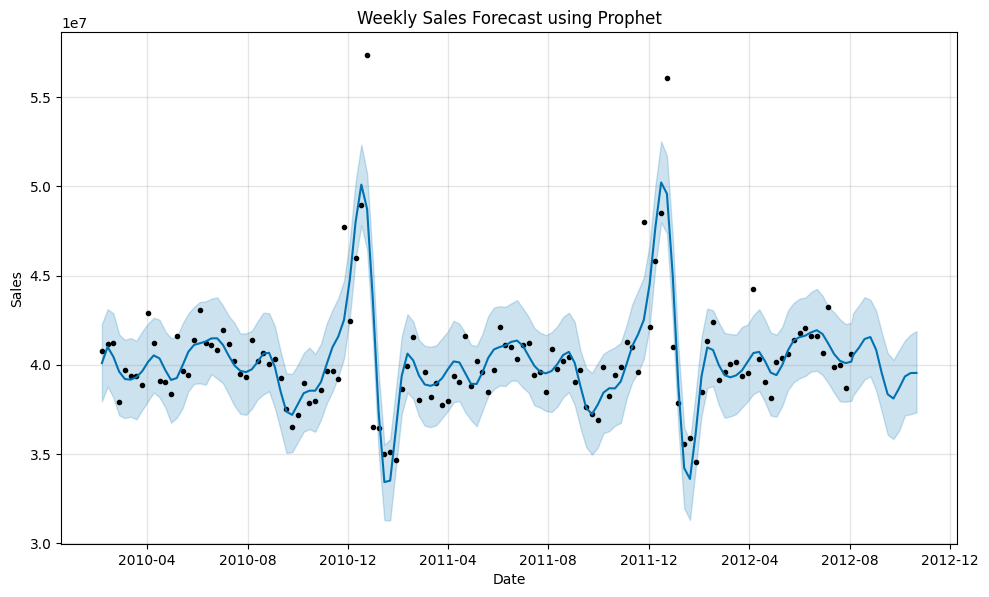

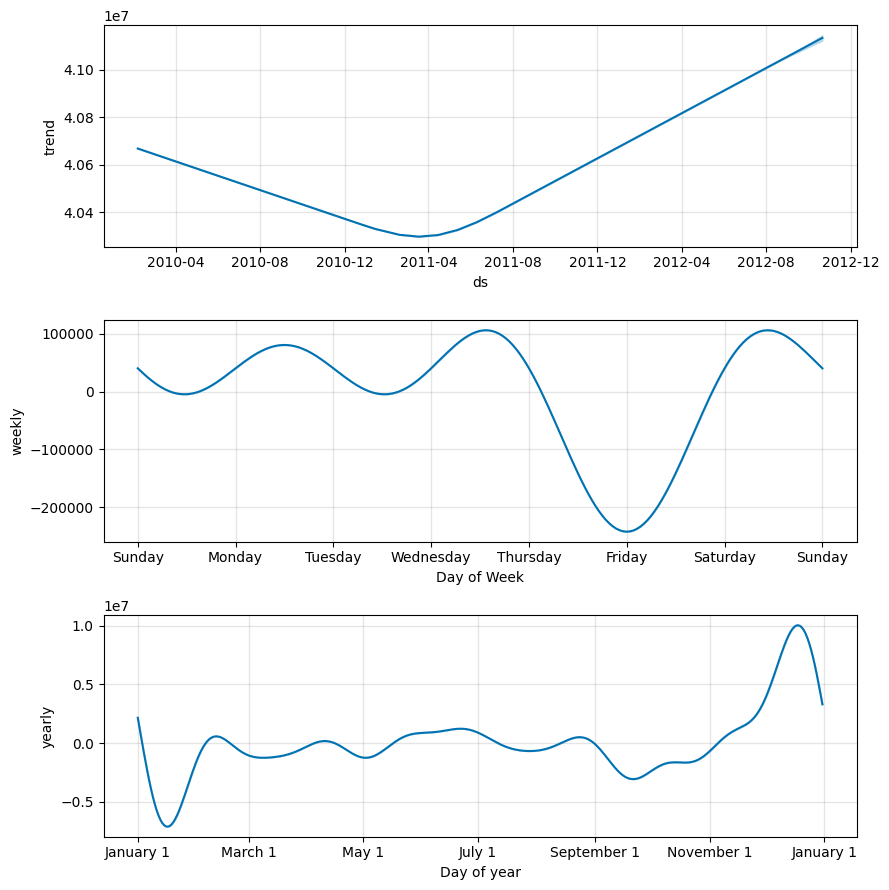

In [38]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare Data 
# Aggregate weekly sales by date
prophet_df = df.groupby('Date')['Weekly_Sales_Capped'].sum().reset_index()
prophet_df.columns = ['ds', 'y']

# Sort by date (important for time series)
prophet_df = prophet_df.sort_values('ds')

# Train-Test Split (Time-based) 
# Last 12 weeks for testing
train = prophet_df.iloc[:-12]
test = prophet_df.iloc[-12:]

# Build Prophet Model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Train model
prophet_model.fit(train)

# Forecast for Test Period 
future = prophet_model.make_future_dataframe(periods=12, freq='W')
forecast = prophet_model.predict(future)

#Evaluation Metrics
# Actual and predicted values
y_true = test['y'].values
y_pred = forecast.tail(12)['yhat'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Prophet Model Evaluation Metrics")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAPE :", mape, "%")

#  Actual vs Predicted Plot
plt.figure(figsize=(8,4))
plt.plot(test['ds'], y_true, label='Actual Sales', marker='o')
plt.plot(test['ds'], y_pred, label='Predicted Sales', linestyle='--', marker='o')
plt.title('Prophet Forecast: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

#  Full Forecast Plot 
prophet_model.plot(forecast)
plt.title("Weekly Sales Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

#  Trend & Seasonality Components 
prophet_model.plot_components(forecast)
plt.show()


Random Forest Results
MAE  : 1255.481296746495
RMSE : 2448.5809071254353
R2   : 0.972952035689846
MAPE : 361.5528641626612 %


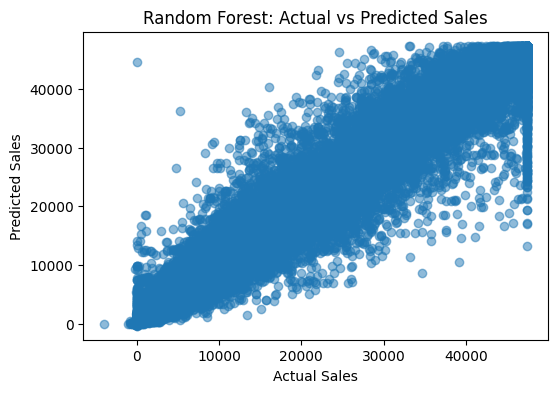

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Select features and target
X = df[['Store', 'Dept', 'Month', 'Quarter', 'IsHoliday']]
y = df['Weekly_Sales_Capped']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,  # number of trees
    random_state=42
)
# Train the model
rf_model.fit(X_train, y_train)
# Make predictions on test data
y_pred = rf_model.predict(X_test)
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)        # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)         # Mean Squared Error
rmse = np.sqrt(mse)                              # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)                    # R-squared score
# Fix MAPE to avoid division by zero errors
non_zero_idx = y_test != 0                       # Select only non-zero actual sales
mape = np.mean(np.abs((y_test[non_zero_idx] - y_pred[non_zero_idx]) / y_test[non_zero_idx])) * 100

# Print results
print("Random Forest Results")
print("MAE  :", mae)
print("RMSE :", rmse)
print("R2   :", r2)
print("MAPE :", mape, "%")

# Plot Actual vs Predicted Sales
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Random Forest: Actual vs Predicted Sales")
plt.show()


### 4. Business Insights Layer 

#### 1.High Revenue Periods

In [40]:
df['DayOfWeek'] = df['Date'].dt.day_name()     # Monday, Tuesday, ...
df['Month'] = df['Date'].dt.month              # 1 to 12
df['MonthEnd'] = df['Date'].dt.is_month_end   
# High revenue by day of week
weekly_sales = df.groupby('DayOfWeek')['Weekly_Sales_Capped'].sum().sort_values(ascending=False)
print("High revenue days of week:\n", weekly_sales)

# High revenue by month
monthly_sales = df.groupby('Month')['Weekly_Sales_Capped'].sum().sort_values(ascending=False)
print("\nHigh revenue months:\n", monthly_sales)

# High revenue on month-end
month_end_sales = df[df['MonthEnd'] == True]['Weekly_Sales_Capped'].sum()
print("\nTotal sales on month-end days:", month_end_sales)


High revenue days of week:
 DayOfWeek
Friday    5.754180e+09
Name: Weekly_Sales_Capped, dtype: float64

High revenue months:
 Month
7     5.636435e+08
4     5.591552e+08
6     5.385729e+08
8     5.269252e+08
3     5.106371e+08
10    5.068959e+08
9     4.993458e+08
5     4.826670e+08
2     4.804330e+08
12    4.647432e+08
11    3.360883e+08
1     2.850725e+08
Name: Weekly_Sales_Capped, dtype: float64

Total sales on month-end days: 152347575.14375


#### 2.Underperforming Product Categories

In [41]:
# Aggregate sales by department
dept_sales = df.groupby('Dept')['Weekly_Sales_Capped'].sum().sort_values()
print("Underperforming Departments (low sales):\n", dept_sales.head(10))  # bottom 10


Underperforming Departments (low sales):
 Dept
47      -4962.93
43         14.32
39        177.98
78       1714.71
51      30572.83
45      44937.63
77      49344.27
99     358149.85
54     516294.63
60    2005020.96
Name: Weekly_Sales_Capped, dtype: float64


#### 3.Forecasted Sales for Next 30/60 Days

In [42]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = df.groupby('Date')['Weekly_Sales_Capped'].sum().reset_index()
prophet_df.rename(columns={'Date':'ds', 'Weekly_Sales_Capped':'y'}, inplace=True)

# Fit model
model = Prophet()
model.fit(prophet_df)

# Forecast next 60 days
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

# Display forecast for next 30/60 days
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(60))


16:12:11 - cmdstanpy - INFO - Chain [1] start processing
16:12:11 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
143 2012-10-27  3.965586e+07  3.748168e+07  4.181135e+07
144 2012-10-28  3.975287e+07  3.741185e+07  4.199854e+07
145 2012-10-29  3.986400e+07  3.780502e+07  4.197751e+07
146 2012-10-30  3.998809e+07  3.768733e+07  4.200418e+07
147 2012-10-31  4.012362e+07  3.800317e+07  4.212309e+07
148 2012-11-01  4.026874e+07  3.823425e+07  4.242670e+07
149 2012-11-02  4.042135e+07  3.841300e+07  4.252157e+07
150 2012-11-03  4.057920e+07  3.834769e+07  4.274872e+07
151 2012-11-04  4.073992e+07  3.868463e+07  4.284263e+07
152 2012-11-05  4.090113e+07  3.875986e+07  4.314880e+07
153 2012-11-06  4.106053e+07  3.883891e+07  4.326130e+07
154 2012-11-07  4.121599e+07  3.918516e+07  4.337940e+07
155 2012-11-08  4.136561e+07  3.930455e+07  4.343885e+07
156 2012-11-09  4.150785e+07  3.933277e+07  4.370834e+07
157 2012-11-10  4.164154e+07  3.938676e+07  4.392990e+07
158 2012-11-11  4.176596e+07  3.965618e+07  4.372472e+07
159 2012-11-12  4.188092e+07  3

#### 4.Recommendations for Inventory Planning

In [43]:
# Example: If forecasted sales > historical max, plan inventory increase
max_historical_sales = df['Weekly_Sales_Capped'].max()
forecast['Inventory_Recommendation'] = forecast['yhat'].apply(
    lambda x: 'Increase Stock' if x > max_historical_sales else 'Normal Stock'
)

print(forecast[['ds', 'yhat', 'Inventory_Recommendation']].tail(30))


            ds          yhat Inventory_Recommendation
173 2012-11-26  4.352438e+07           Increase Stock
174 2012-11-27  4.376468e+07           Increase Stock
175 2012-11-28  4.403595e+07           Increase Stock
176 2012-11-29  4.433896e+07           Increase Stock
177 2012-11-30  4.467362e+07           Increase Stock
178 2012-12-01  4.503897e+07           Increase Stock
179 2012-12-02  4.543309e+07           Increase Stock
180 2012-12-03  4.585314e+07           Increase Stock
181 2012-12-04  4.629530e+07           Increase Stock
182 2012-12-05  4.675486e+07           Increase Stock
183 2012-12-06  4.722621e+07           Increase Stock
184 2012-12-07  4.770300e+07           Increase Stock
185 2012-12-08  4.817814e+07           Increase Stock
186 2012-12-09  4.864399e+07           Increase Stock
187 2012-12-10  4.909249e+07           Increase Stock
188 2012-12-11  4.951529e+07           Increase Stock
189 2012-12-12  4.990392e+07           Increase Stock
190 2012-12-13  5.025001e+07

#### for powerbi data should cleaned so convert it into seperate file

In [44]:
columns_needed = ['Date', 'Store', 'Dept', 'Weekly_Sales_Capped', 'IsHoliday']
df_dashboard = df[columns_needed]


In [45]:
df_dashboard.to_csv("dashboard_data.csv", index=False)
df_dashboard.head()


,Date,Store,Dept,Weekly_Sales_Capped,IsHoliday
0,2010-02-05,1,1,24924.50,False
1,2010-02-12,1,1,46039.49,True
2,2010-02-19,1,1,41595.55,False
3,2010-02-26,1,1,19403.54,False
4,2010-03-05,1,1,21827.90,False


#### DEPLOY 

In [48]:
import pickle

pickle.dump(model, open("sales_model.pkl", "wb"))
print("Sales model saved successfully")


Sales model saved successfully


In [51]:
%%writefile app.py
import streamlit as st
import pickle
import pandas as pd

# ------------------ Page Configuration ------------------
st.set_page_config(
    page_title="Sales Forecasting System",
    page_icon="📈",
    layout="centered"
)

# ------------------ Custom Styling ------------------
st.markdown("""
    <style>
    .main {
        background-color: #f7f9fc;
    }
    .title {
        font-size: 36px;
        font-weight: 700;
        color: #2c3e50;
        text-align: center;
        margin-bottom: 10px;
    }
    .subtitle {
        font-size: 18px;
        color: #555;
        text-align: center;
        margin-bottom: 30px;
    }
    .card {
        background-color: #ffffff;
        padding: 25px;
        border-radius: 15px;
        box-shadow: 0px 4px 15px rgba(0,0,0,0.08);
        margin-bottom: 20px;
    }
    .result {
        font-size: 28px;
        font-weight: 600;
        color: #1e8449;
        text-align: center;
    }
    </style>
""", unsafe_allow_html=True)

# ------------------ Load Model ------------------
model = pickle.load(open("sales_model.pkl", "rb"))

# ------------------ Title ------------------
st.markdown('<div class="title">📈 Sales Forecasting System</div>', unsafe_allow_html=True)
st.markdown('<div class="subtitle">Predict future sales using historical data</div>', unsafe_allow_html=True)

# ------------------ Input Section ------------------
st.markdown('<div class="card">', unsafe_allow_html=True)
st.subheader("🔍 Select Forecast Date")
st.write("Choose a future date to estimate expected sales.")
forecast_date = st.date_input("Forecast Date")
st.markdown('</div>', unsafe_allow_html=True)

# ------------------ Prediction ------------------
if st.button("🚀 Predict Sales"):
    future_df = pd.DataFrame({
        "ds": [pd.to_datetime(forecast_date)]
    })

    forecast = model.predict(future_df)
    predicted_sales = forecast["yhat"].iloc[0]

    st.markdown('<div class="card">', unsafe_allow_html=True)
    st.markdown(
        f'<div class="result">Estimated Sales<br>₹ {predicted_sales:,.2f}</div>',
        unsafe_allow_html=True
    )
    st.markdown('</div>', unsafe_allow_html=True)

# ------------------ Footer ------------------
st.markdown(
    "<hr><center><small>Sales Forecasting Project | Streamlit Deployment</small></center>",
    unsafe_allow_html=True
)


Overwriting app.py
